In [2]:
! python -m pip install -q  numpy pandas seaborn scikit-learn matplotlib tensorflow keras sgp4 scipy openpyxl

print("bibliotecas instaladas")

bibliotecas instaladas


In [12]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sgp4.api import Satrec
from scipy.spatial.transform import Rotation as R

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [13]:
# ----- Para um satelite -----

# TLE da ISS (ZARYA)             
line1 = "1 25544U 98067A   24106.45347222  .00012190  00000+0  21377-3 0  9992"
line2 = "2 25544  51.6414  52.8843 0003046  96.6780  42.0736 15.51762384294959"
sat = Satrec.twoline2rv(line1, line2)

# Função auxiliar
def datetime_to_julian_date(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute, second = dt.hour, dt.minute, dt.second + dt.microsecond / 1e6
    jd = 367 * year - int((7 * (year + int((month + 9) / 12))) / 4) \
         + int((275 * month) / 9) + day + 1721013.5 \
         + (hour + minute / 60 + second / 3600) / 24
    fr = (hour + minute / 60 + second / 3600) / 24 % 1
    return jd, fr

# Parâmetros
base_time = datetime.utcnow()
intervalo_segundos = 30
samples = 3000 # priemeiro teste foi com 200 amostras apenas (94% de acurácia)
tempos, q0, q1, q2, q3 = [], [], [], [], []
rolls, pitchs, yaws = [], [], []

# Loop de propagação
for i in range(samples):
    dt = base_time + timedelta(seconds=i * intervalo_segundos)
    jd, fr = datetime_to_julian_date(dt)
    err, position, velocity = sat.sgp4(jd, fr)

    if err != 0:
        print(f"Erro na propagação para t={dt}, código: {err}")
        continue

    r = np.array(position)
    v = np.array(velocity)

    z = -r / np.linalg.norm(r)
    y = np.cross(z, v); y /= np.linalg.norm(y)
    x = np.cross(y, z)
    rot_matrix = np.vstack([x, y, z]).T
    rotation = R.from_matrix(rot_matrix)

    quat = rotation.as_quat()   # x, y, z, w
    euler = rotation.as_euler('xyz', degrees=True)

    tempos.append(i * intervalo_segundos)
    q0.append(quat[3]); q1.append(quat[0]); q2.append(quat[1]); q3.append(quat[2])
    rolls.append(euler[0]); pitchs.append(euler[1]); yaws.append(euler[2])

# Rotulagem automática
def rotular_gimbal_lock(pitch, tolerancia=2):
    if abs(pitch - 90) < tolerancia:
        return "gimbal_lock"
    elif abs(pitch - 90) < tolerancia + 5:
        return "alerta"
    else:
        return "ok"

# DataFrame final
df = pd.DataFrame({
    'tempo': tempos,
    'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3,
    'roll': rolls,
    'pitch': pitchs,
    'yaw': yaws
})
df['status'] = df['pitch'].apply(rotular_gimbal_lock)

print(df.head())
df.to_excel("dados_orientacao_IA.xlsx", index=False) # visualização

   tempo        q0        q1        q2        q3       roll      pitch  \
0      0  0.369537 -0.586786 -0.131782  0.708349 -65.967337  47.214468   
1     30  0.364836 -0.562258 -0.144332  0.727962 -62.274629  45.503250   
2     60  0.359712 -0.537078 -0.156714  0.746723 -58.919764  43.578934   
3     90  0.354172 -0.511275 -0.168913  0.764610 -55.897017  41.468144   
4    120  0.348222 -0.484879 -0.180915  0.781603 -53.192228  39.195538   

          yaw status  
0   93.228063     ok  
1   98.328606     ok  
2  103.109490     ok  
3  107.579738     ok  
4  111.756979     ok  


In [11]:
# ----- Comparar dois TLEs para validação -----

# Função auxiliar para converter para data Juliana
def datetime_to_julian_date(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute, second = dt.hour, dt.minute, dt.second + dt.microsecond / 1e6
    jd = 367 * year - int((7 * (year + int((month + 9) / 12))) / 4) \
         + int((275 * month) / 9) + day + 1721013.5 \
         + (hour + minute / 60 + second / 3600) / 24
    fr = (hour + minute / 60 + second / 3600) / 24 % 1
    return jd, fr

# Rotulagem automática
def rotular_gimbal_lock(pitch, tolerancia=2):
    if abs(pitch - 90) < tolerancia:
        return "gimbal_lock"
    elif abs(pitch - 90) < tolerancia + 5:
        return "alerta"
    else:
        return "ok"

# Pipeline para um satélite
def pipeline_orientacao(tle_line1, tle_line2, nome="SAT", intervalo_segundos=30, samples=3000):
    print(f"Processando: {nome}")
    sat = Satrec.twoline2rv(tle_line1, tle_line2)
    base_time = datetime.utcnow()

    tempos, q0, q1, q2, q3 = [], [], [], [], []
    rolls, pitchs, yaws = [], [], []

    for i in range(samples):
        dt = base_time + timedelta(seconds=i * intervalo_segundos)
        jd, fr = datetime_to_julian_date(dt)
        err, position, velocity = sat.sgp4(jd, fr)

        if err != 0:
            print(f"Erro na propagação para t={dt}, código: {err}")
            continue

        r = np.array(position)
        v = np.array(velocity)

        z = -r / np.linalg.norm(r)
        y = np.cross(z, v); y /= np.linalg.norm(y)
        x = np.cross(y, z)
        rot_matrix = np.vstack([x, y, z]).T
        rotation = R.from_matrix(rot_matrix)

        quat = rotation.as_quat()   # x, y, z, w
        euler = rotation.as_euler('xyz', degrees=True)

        tempos.append(i * intervalo_segundos)
        q0.append(quat[3]); q1.append(quat[0]); q2.append(quat[1]); q3.append(quat[2])
        rolls.append(euler[0]); pitchs.append(euler[1]); yaws.append(euler[2])

    df = pd.DataFrame({ # dataframe final
        'tempo': tempos,
        'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3,
        'roll': rolls,
        'pitch': pitchs,
        'yaw': yaws
    })
    df['status'] = df['pitch'].apply(rotular_gimbal_lock)

    output_name = f"dados_orientacao_{nome.upper()}.xlsx"
    df.to_excel(output_name, index=False)
    print(f"{nome} concluído. Dados salvos em {output_name}")
    return df

# ISS
line1_iss = "1 25544U 98067A   24106.45347222  .00012190  00000+0  21377-3 0  9992"
line2_iss = "2 25544  51.6414  52.8843 0003046  96.6780  42.0736 15.51762384294959"

# HST
line1_hst = "1 20580U 90037B   25150.31357661  .00005233  00000+0  19471-3 0  9996"
line2_hst = "2 20580  28.4662 166.0532 0002301 246.7201 113.3151 15.25130299729950"

# Executar para os dois satélites
df_iss = pipeline_orientacao(line1_iss, line2_iss, nome="ISS")
df_hst = pipeline_orientacao(line1_hst, line2_hst, nome="HST")

# Exibir primeiras linhas
print(df_iss.head())
print(df_hst.head())


Processando: ISS
ISS concluído. Dados salvos em dados_orientacao_ISS.xlsx
Processando: HST
HST concluído. Dados salvos em dados_orientacao_HST.xlsx
   tempo        q0        q1        q2        q3        roll      pitch  \
0      0 -0.392246  0.781847  0.007220 -0.484568 -109.745669  48.768452   
1     30 -0.391764  0.764829  0.020613 -0.511012 -105.392101  49.953523   
2     60 -0.390826  0.746918  0.033983 -0.536856 -100.777768  50.842355   
3     90 -0.389433  0.728136  0.047314 -0.562068  -95.967619  51.414014   
4    120 -0.387588  0.708507  0.060591 -0.586620  -91.044154  51.654073   

         yaw status  
0  36.432834     ok  
1  42.167740     ok  
2  48.154188     ok  
3  54.330099     ok  
4  60.615788     ok  
   tempo        q0        q1        q2        q3       roll      pitch  \
0      0  0.066933  0.080525 -0.528006  0.842761 -63.966149 -11.911962   
1     30  0.049353  0.108545 -0.529938  0.839612 -64.743440 -13.566859   
2     60  0.031718  0.136445 -0.531284  0.83553

Distribuição dos rótulos gerados:
 status
ok             3010
gimbal_lock      10
alerta           10
Name: count, dtype: int64
Rótulos codificados: ['alerta' 'gimbal_lock' 'ok']
Epoch 1/50


c:\Users\jaysa.gabrielly\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9379 - loss: 0.2985 - val_accuracy: 0.9917 - val_loss: 0.0185
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9957 - loss: 0.0182 - val_accuracy: 0.9917 - val_loss: 0.0155
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9950 - loss: 0.0107 - val_accuracy: 0.9938 - val_loss: 0.0144
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9977 - loss: 0.0122 - val_accuracy: 0.9938 - val_loss: 0.0134
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9987 - loss: 0.0128 - val_accuracy: 0.9938 - val_loss: 0.0128
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 0.9938 - val_loss: 0.0122
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9938 - val_loss: 0.0106
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.993

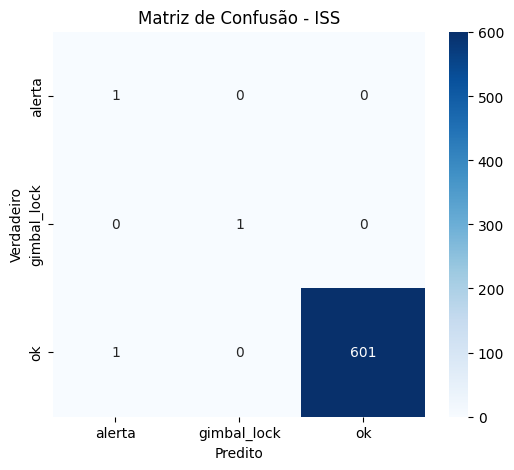

Relatório de Classificação - ISS:

              precision    recall  f1-score   support

      alerta       0.50      1.00      0.67         1
 gimbal_lock       1.00      1.00      1.00         1
          ok       1.00      1.00      1.00       602

    accuracy                           1.00       604
   macro avg       0.83      1.00      0.89       604
weighted avg       1.00      1.00      1.00       604


Exemplo de previsões para novas sequências (ISS):

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Amostra 1: Classe prevista = ok, Probabilidades = [1.8183460e-06 3.2674980e-05 9.9996555e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Amostra 2: Classe prevista = ok, Probabilidades = [2.8112677e-06 7.1691866e-06 9.9998999e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Amostra 3: Classe prevista = ok, Probabilidades = [2.1989590e-06 1.7888224e-05 9.9997997e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Amostra 4: Classe prevista = ok, Probabilidades = [3.4243803e-06 1.9409414e-05 9.9997711e-01]
1/1 

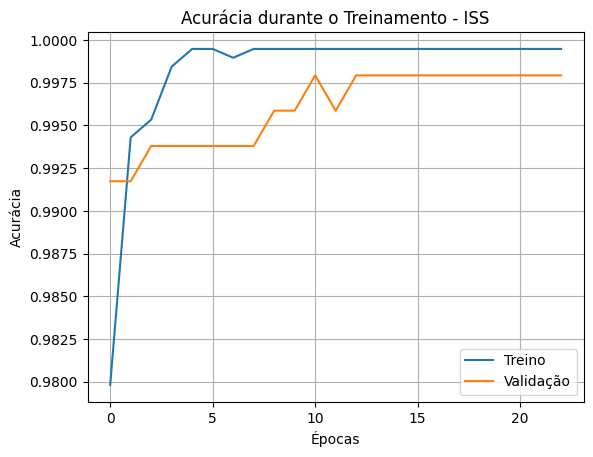

In [17]:
# Carrega os dados da ISS
df = pd.read_excel("dados_orientacao_ISS.xlsx")

# Rótulo automático com base no pitch
def rotulo(pitch):
    if abs(pitch - 90) < 2:
        return 'gimbal_lock'
    elif abs(pitch - 90) < 7:
        return 'alerta'
    else:
        return 'ok'

df['status'] = df['pitch'].apply(rotulo)

# Dados sintéticos para reforço supervisionado
df_fake = pd.DataFrame({
    'tempo': range(30),
    'q0': np.random.uniform(-1, 1, 30),
    'q1': np.random.uniform(-1, 1, 30),
    'q2': np.random.uniform(-1, 1, 30),
    'q3': np.random.uniform(-1, 1, 30),
    'roll': np.random.uniform(-180, 180, 30),
    'pitch': np.concatenate([
        np.full(10, 90),     # gimbal_lock
        np.full(10, 88),     # alerta
        np.full(10, 100)     # ok
    ]),
    'yaw': np.random.uniform(-180, 180, 30)
})
df_fake['status'] = df_fake['pitch'].apply(rotulo)

# Junta com os dados reais
df = pd.concat([df, df_fake], ignore_index=True)

# Codificação dos rótulos
encoder = LabelEncoder()
y_raw = encoder.fit_transform(df['status'])
print("Distribuição dos rótulos gerados:\n", df['status'].value_counts())
print("Rótulos codificados:", encoder.classes_)

# Preparação de janelas temporais
features = ['q0', 'q1', 'q2', 'q3', 'roll', 'pitch', 'yaw']
window_size = 10
X, y = [], []
for i in range(len(df) - window_size):
    seq_x = df[features].iloc[i:i+window_size].values
    label = y_raw[i + window_size]
    X.append(seq_x)
    y.append(label)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y)

# Separação em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, len(features))))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Avaliação final
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Acurácia (ISS): {acc:.2f} | Loss: {loss:.4f}")

# ---------- Matriz de Confusão ----------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Previsão
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Matriz
cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - ISS")
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# Relatório de Classificação
print("Relatório de Classificação - ISS:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Previsões exemplo
print("\nExemplo de previsões para novas sequências (ISS):\n")
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    print(f"Amostra {i+1}: Classe prevista = {pred_class}, Probabilidades = {pred_prob}")

# Curva de acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia durante o Treinamento - ISS")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()


Distribuição dos rótulos gerados:
 status
ok             3010
gimbal_lock      10
alerta           10
Name: count, dtype: int64
Rótulos codificados: ['alerta' 'gimbal_lock' 'ok']
Epoch 1/50


c:\Users\jaysa.gabrielly\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7928 - loss: 0.4394 - val_accuracy: 0.9917 - val_loss: 0.0168
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9949 - loss: 0.0149 - val_accuracy: 0.9917 - val_loss: 0.0145
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9962 - loss: 0.0167 - val_accuracy: 0.9938 - val_loss: 0.0111
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9972 - loss: 0.0131 - val_accuracy: 0.9979 - val_loss: 0.0089
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9979 - loss: 0.0062 - val_accuracy: 0.9979 - val_loss: 0.0073
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9989 - loss: 0.0074 - val_accuracy: 0.9979 - val_loss: 0.0062
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9995 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9982 - loss: 0.0090 - val_accuracy: 1.000

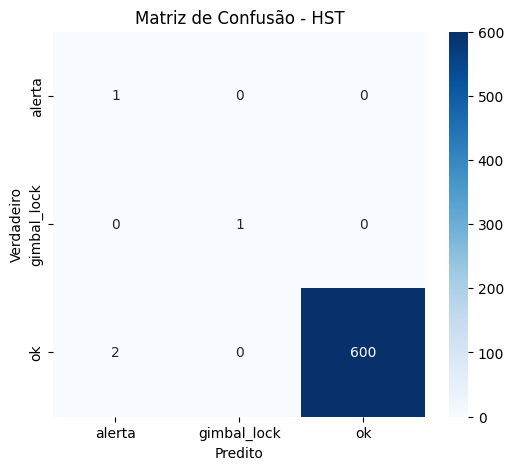

Relatório de Classificação - HST:

              precision    recall  f1-score   support

      alerta       0.33      1.00      0.50         1
 gimbal_lock       1.00      1.00      1.00         1
          ok       1.00      1.00      1.00       602

    accuracy                           1.00       604
   macro avg       0.78      1.00      0.83       604
weighted avg       1.00      1.00      1.00       604


Exemplo de previsões para novas sequências (HST):

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Amostra 1: Classe prevista = ok, Probabilidades = [8.7243620e-07 5.8768063e-07 9.9999857e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Amostra 2: Classe prevista = ok, Probabilidades = [2.3287396e-07 3.0497310e-06 9.9999666e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Amostra 3: Classe prevista = ok, Probabilidades = [3.9985134e-06 3.2721048e-06 9.9999273e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Amostra 4: Classe prevista = ok, Probabilidades = [1.2661193e-06 1.1302196e-06 9.9999762e-01]
1/1 

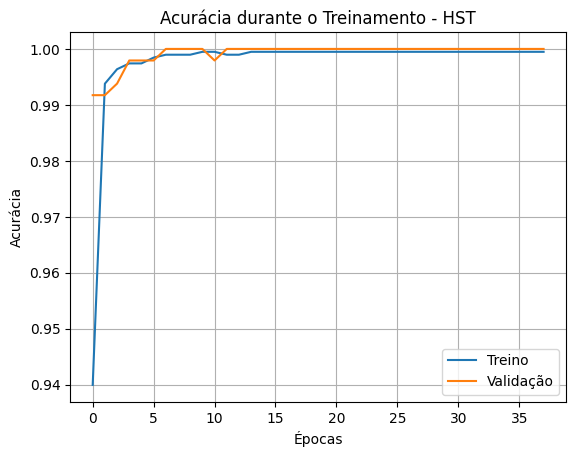

In [18]:
# Carrega os dados do HST
df = pd.read_excel("dados_orientacao_HST.xlsx")

# Rótulo automático com base no pitch
def rotulo(pitch):
    if abs(pitch - 90) < 2:
        return 'gimbal_lock'
    elif abs(pitch - 90) < 7:
        return 'alerta'
    else:
        return 'ok'

df['status'] = df['pitch'].apply(rotulo)

# Dados sintéticos para reforço supervisionado (pode remover se já tiver suficientes)
df_fake = pd.DataFrame({
    'tempo': range(30),
    'q0': np.random.uniform(-1, 1, 30),
    'q1': np.random.uniform(-1, 1, 30),
    'q2': np.random.uniform(-1, 1, 30),
    'q3': np.random.uniform(-1, 1, 30),
    'roll': np.random.uniform(-180, 180, 30),
    'pitch': np.concatenate([
        np.full(10, 90),     # gimbal_lock
        np.full(10, 88),     # alerta
        np.full(10, 100)     # ok
    ]),
    'yaw': np.random.uniform(-180, 180, 30)
})
df_fake['status'] = df_fake['pitch'].apply(rotulo)

# Junta com os dados reais
df = pd.concat([df, df_fake], ignore_index=True)

# Codificação dos rótulos
encoder = LabelEncoder()
y_raw = encoder.fit_transform(df['status'])
print("Distribuição dos rótulos gerados:\n", df['status'].value_counts())
print("Rótulos codificados:", encoder.classes_)

# Preparação de janelas temporais
features = ['q0', 'q1', 'q2', 'q3', 'roll', 'pitch', 'yaw']
window_size = 10
X, y = [], []
for i in range(len(df) - window_size):
    seq_x = df[features].iloc[i:i+window_size].values
    label = y_raw[i + window_size]
    X.append(seq_x)
    y.append(label)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y)

# Separação em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, len(features))))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Avaliação final
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Acurácia (HST): {acc:.2f} | Loss: {loss:.4f}")

# ---------- Matriz de Confusão ----------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Previsão
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Matriz
cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - HST")
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# Relatório de Classificação
print("Relatório de Classificação - HST:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Previsões exemplo
print("\nExemplo de previsões para novas sequências (HST):\n")
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    print(f"Amostra {i+1}: Classe prevista = {pred_class}, Probabilidades = {pred_prob}")

# Curva de acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia durante o Treinamento - HST")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# para salvar os dados
# extensão: H5Web
from tensorflow.keras.models import load_model
model.save("modelo_gimbal_lock.h5")

# model = load_model("modelo_gimbal_lock.h5")

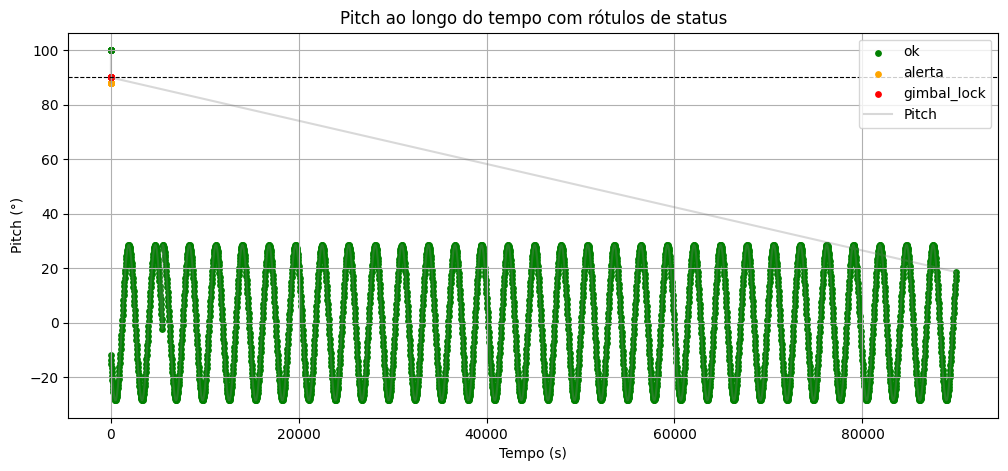

In [20]:
import matplotlib.pyplot as plt

cores = {'ok': 'green', 'alerta': 'orange', 'gimbal_lock': 'red'}

plt.figure(figsize=(12, 5))
for status, cor in cores.items():
    subset = df[df['status'] == status]
    plt.scatter(subset['tempo'], subset['pitch'], label=status, color=cor, s=15)

plt.plot(df['tempo'], df['pitch'], color='gray', alpha=0.3, label='Pitch')
plt.axhline(90, color='black', linestyle='--', linewidth=0.8)
plt.title("Pitch ao longo do tempo com rótulos de status")
plt.xlabel("Tempo (s)")
plt.ylabel("Pitch (°)")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    
    print(f"\n🛰️ Amostra {i+1} - Classe prevista: {pred_class}")
    print(f"Probabilidades: {pred_prob}")
    print("Sequência de pitchs:")
    print(X_test[i][:, features.index('pitch')])  # extrai os valores de pitch da sequência

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

🛰️ Amostra 1 - Classe prevista: ok
Probabilidades: [8.7243620e-07 5.8768063e-07 9.9999857e-01]
Sequência de pitchs:
[28.12438919 27.74408706 27.23172593 26.59136519 25.82791346 24.94700121
 23.95484192 22.85809972 21.66376225 20.37902636]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

🛰️ Amostra 2 - Classe prevista: ok
Probabilidades: [2.3287396e-07 3.0497310e-06 9.9999666e-01]
Sequência de pitchs:
[-18.08696843 -16.5970441  -15.04315439 -13.43246058 -11.77199724
 -10.06866086  -8.32920889  -6.56026748  -4.76834602  -2.95985587]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

🛰️ Amostra 3 - Classe prevista: ok
Probabilidades: [3.9985134e-06 3.2721048e-06 9.9999273e-01]
Sequência de pitchs:
[ 9.52339837  7.77581915  6.00092621  4.20516835  2.39490338  0.57642323
 -1.24401853 -3.06017795 -4.86579158 -6.65454802]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

🛰️ Amostra 4 - Classe prevista: ok
Probabilidades: [1.2661193e-06 1.1302196e-06 9.9999762e-01]
Sequência de pitchs:


In [22]:
print(f"\nAvaliação Final:")
print(f"Acurácia: {acc:.2f} | Loss: {loss:.4f}")
print("\nMatriz de Confusão e Classificação:")
print(classification_report(y_true, y_pred, target_names=labels))


Avaliação Final:
Acurácia: 1.00 | Loss: 0.0077

Matriz de Confusão e Classificação:
              precision    recall  f1-score   support

      alerta       0.33      1.00      0.50         1
 gimbal_lock       1.00      1.00      1.00         1
          ok       1.00      1.00      1.00       602

    accuracy                           1.00       604
   macro avg       0.78      1.00      0.83       604
weighted avg       1.00      1.00      1.00       604

